# Data analysis

## Import all third-party libraries

In [109]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr, kendalltau

## Get data

In [2]:
DATA_DIR = 'data/'

with open(f"{DATA_DIR}train_hh.json") as f:
    hh_dialog = json.load(f)

with open(f"{DATA_DIR}train_hb.json") as f:
    hb_dialog = json.load(f)

## Helper functions

In [89]:
UTT_LEN_LIMIT = 25
NP_LEN_LIMIT = 25
NLL_LIMIT = 10**3

In [90]:
def calc_average_utt_len(dataset):
    avg_utts = []
    for d in dataset:
        utterances = 0
        utt_lengths = 0
        for th in d['thread']:
            if th['UTT_LEN'] <= UTT_LEN_LIMIT:
                utterances += 1
                utt_lengths += th['UTT_LEN']
        if utterances != 0 and utt_lengths / utterances <= 25:
            avg_utts.append(utt_lengths / utterances)
    return avg_utts

In [91]:
def calc_average_np_len(dataset):
    avg_nps = []
    for d in dataset:
        utterances = 0
        np_lengths = 0
        for th in d['thread']:
            if th['NP_LEN'] <= NP_LEN_LIMIT:
                utterances += 1
                np_lengths += th['NP_LEN']
        if utterances != 0:
            avg_nps.append(np_lengths / utterances)
    return avg_nps

In [92]:
def calc_average_nll(dataset):
    avg_nll = []
    for d in dataset:
        utterances = 0
        nlls = 0
        for th in d['thread']:
            if 'NLL' in th and th['NLL'] <= NLL_LIMIT:
                utterances += 1
                nlls += th['NLL']
        if utterances != 0:
            avg_nll.append(nlls / utterances)
    return avg_nll

## Draw histograms with normal distribution

### Utterance length

In [75]:
def get_hist_with_norm_dist(data, title, bins=25):
    _, bins, _ = plt.hist(data, bins=bins, density=1, alpha=0.5)
    mu, sigma = norm.fit(data)
    best_fit_line = norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line)
    plt.title(f'{title}, mean={round(mu,2)}, st.dev.={round(sigma,2)}')

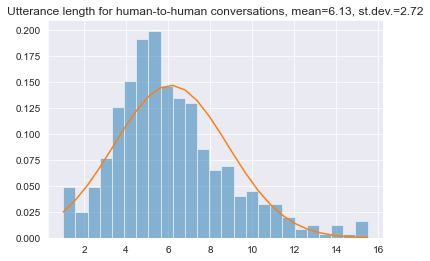

In [76]:
get_hist_with_norm_dist(calc_average_utt_len(hh_dialog), "Utterance length for human-to-human conversations")

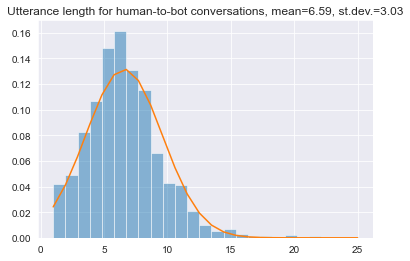

In [77]:
get_hist_with_norm_dist(calc_average_utt_len(hb_dialog), "Utterance length for human-to-bot conversations")

### NP count

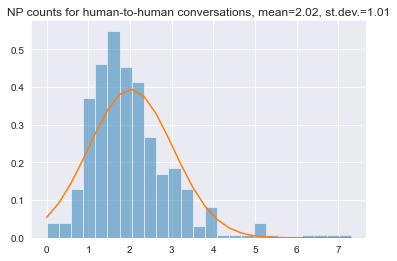

In [78]:
get_hist_with_norm_dist(calc_average_np_len(hh_dialog), "NP counts for human-to-human conversations")

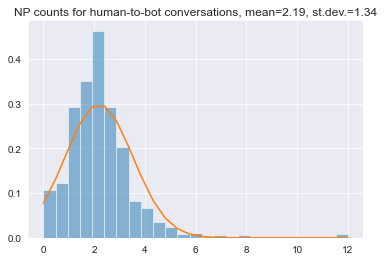

In [79]:
get_hist_with_norm_dist(calc_average_np_len(hb_dialog), "NP counts for human-to-bot conversations")

### NLLs

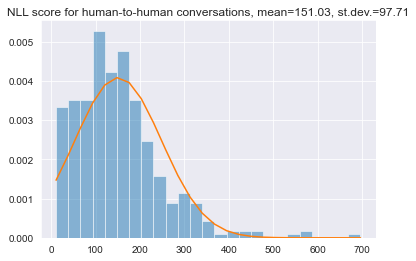

In [93]:
get_hist_with_norm_dist(calc_average_nll(hh_dialog), "NLL score for human-to-human conversations")

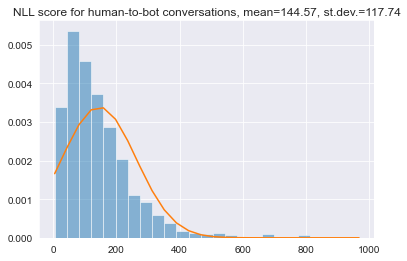

In [94]:
get_hist_with_norm_dist(calc_average_nll(hb_dialog), "NLL score for human-to-bot conversations")

## Correlations

In [95]:
import pandas as pd

In [96]:
def construct_df(dataset, consider_bots=False):
    rows_list = []
    for d in dataset:
        row = {}
        user_1 = d['users'][0]
        user_2 = d['users'][1]
        if consider_bots:
            # Guarantee that user 1 is always human
            if user_1['userType'] == 'Bot':
                user_bot = user_1
                user_1 = user_2
                user_2 = user_bot

        eval_user_1 = [ev for ev in d['evaluation'] if ev['userId'] == user_1['id']][0]
        thread_user_1 = [th for th in d['thread'] if th['userId'] == user_1['id']]
        if thread_user_1:
            utt_user_1 = [th['UTT_LEN'] for th in thread_user_1]
            np_user_1 = [th['NP_LEN'] for th in thread_user_1]
            try:
                nll_user_1 = [th['NLL'] for th in thread_user_1]
            except KeyError:
                nll_user_1 = [0]
            if not consider_bots:
                row['breadth_user_1'] = eval_user_1['breadth']
                row['quality_user_1'] = eval_user_1['quality']
                row['engagement_user_1'] = eval_user_1['engagement']
            row['utt_user_1'] = sum(utt_user_1) / len(utt_user_1)
            row['np_user_1'] = sum(np_user_1) / len(np_user_1)
            row['nll_user_1'] = sum(nll_user_1) / len(nll_user_1)
            if row['nll_user_1'] >= NLL_LIMIT:
                row['nll_user_1'] = NLL_LIMIT

        eval_user_2 = [ev for ev in d['evaluation'] if ev['userId'] == user_2['id']][0]
        thread_user_2 = [th for th in d['thread'] if th['userId'] == user_2['id']]
        if thread_user_2:
            utt_user_2 = [th['UTT_LEN'] for th in thread_user_2]
            np_user_2 = [th['NP_LEN'] for th in thread_user_2]
            try:
                nll_user_2 = [th['NLL'] for th in thread_user_2]
            except KeyError:
                nll_user_2 = [0]
            row['breadth_user_2'] = eval_user_2['breadth']
            row['quality_user_2'] = eval_user_2['quality']
            row['engagement_user_2'] = eval_user_2['engagement']
            row['utt_user_2'] = sum(utt_user_2) / len(utt_user_2)
            row['np_user_2'] = sum(np_user_2) / len(np_user_2)
            row['nll_user_2'] = sum(nll_user_2) / len(nll_user_2)
            if row['nll_user_2'] >= NLL_LIMIT:
                row['nll_user_2'] = NLL_LIMIT

        rows_list.append(row)
    return rows_list

In [97]:
df_hh = pd.DataFrame(data=construct_df(hh_dialog), columns=[
    'breadth_user_1',
    'quality_user_1',
    'engagement_user_1',
    'utt_user_1',
    'np_user_1',
    'nll_user_1',
    'breadth_user_2',
    'quality_user_2',
    'engagement_user_2',
    'utt_user_2',
    'np_user_2',
    'nll_user_2'
])

In [98]:
df_hb = pd.DataFrame(data=construct_df(hb_dialog), columns=[
    'utt_user_1',
    'np_user_1',
    'nll_user_1',
    'breadth_user_2',
    'quality_user_2',
    'engagement_user_2',
    'utt_user_2',
    'np_user_2',
    'nll_user_2'
])

### Graphs

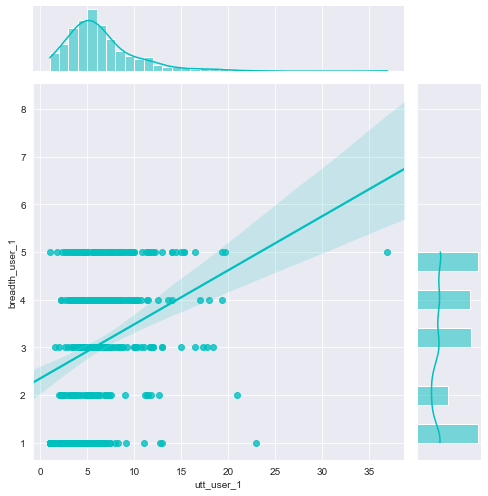

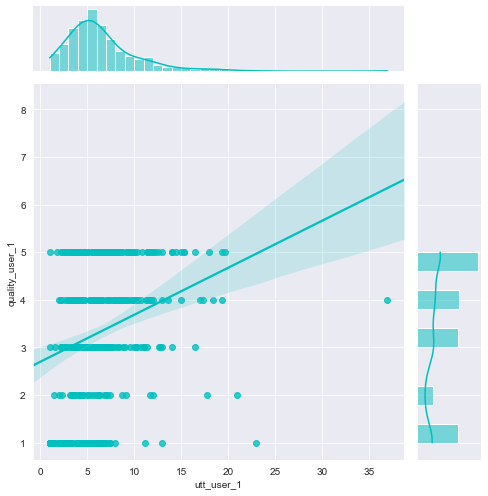

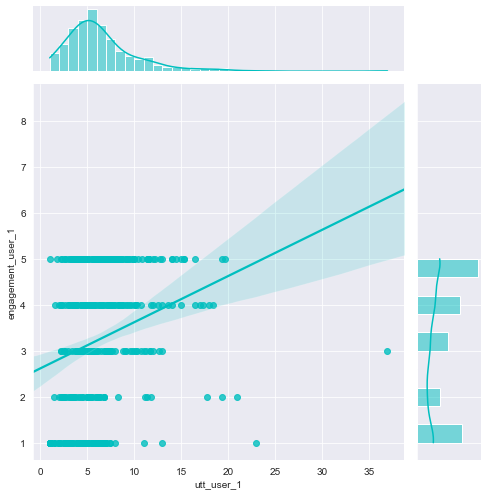

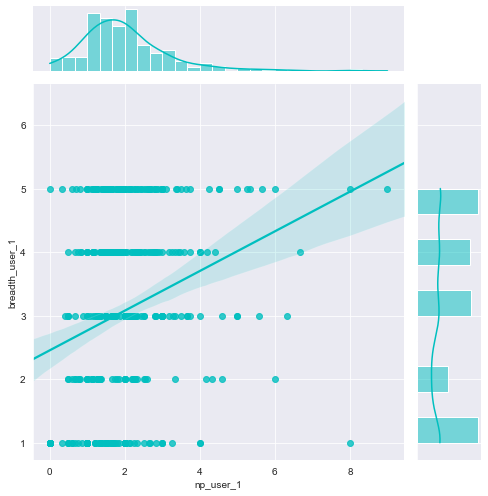

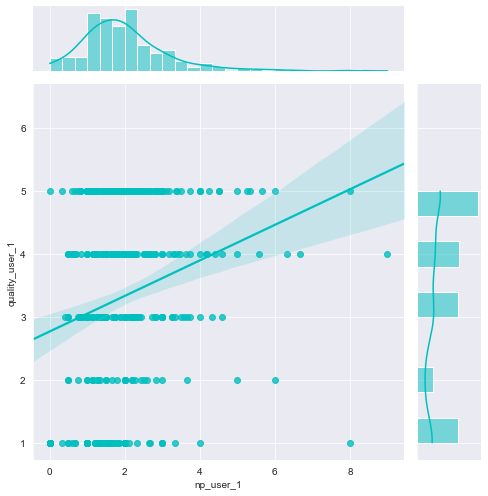

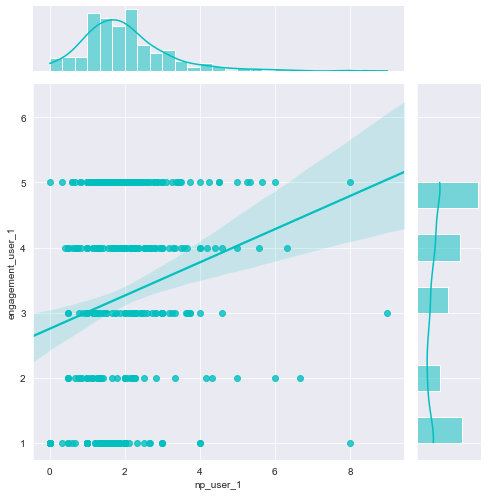

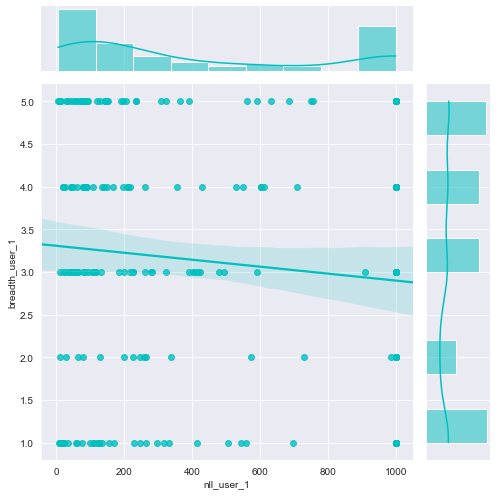

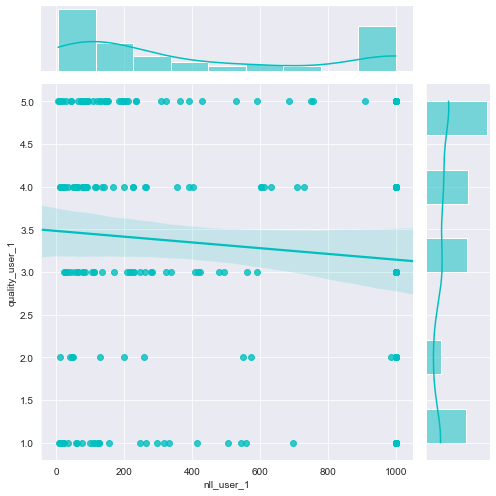

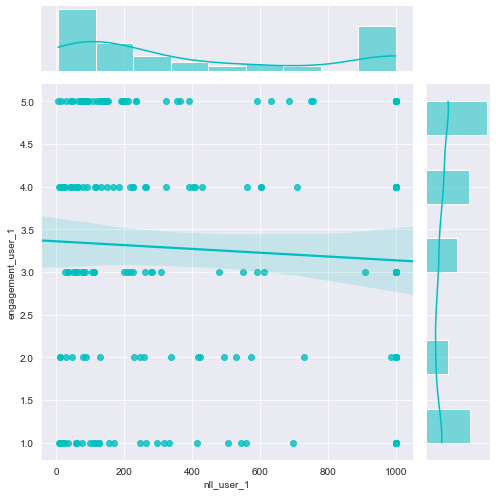

In [99]:
for in_metric in ['utt_user_1', 'np_user_1', 'nll_user_1']:
    for q_metric in ['breadth_user_1', 'quality_user_1', 'engagement_user_1']:
        sns.jointplot(x=in_metric, y=q_metric, data=df_hh,
                      kind="reg", truncate=False,
                      color="c", height=7)

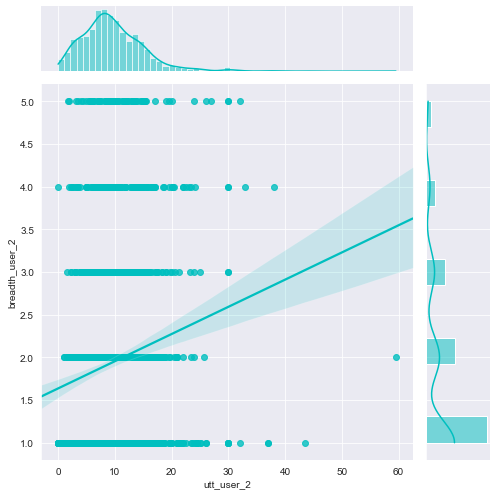

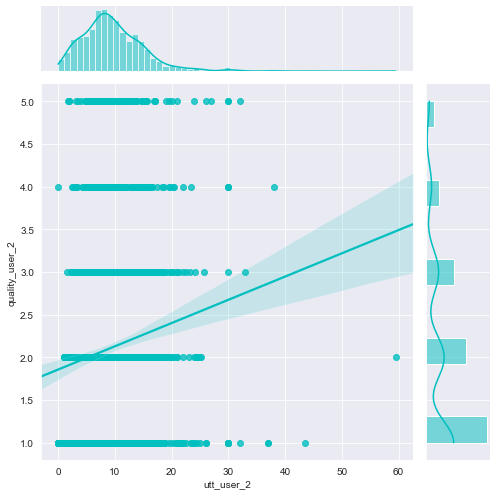

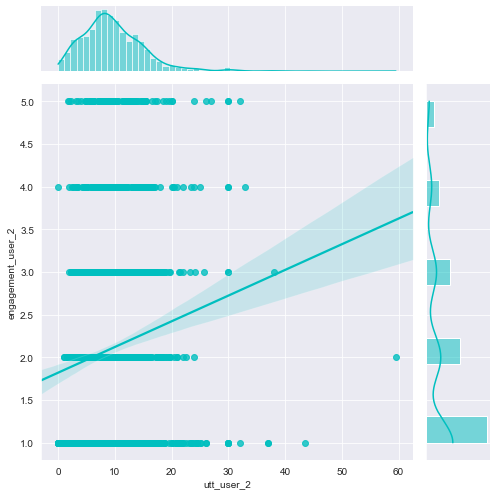

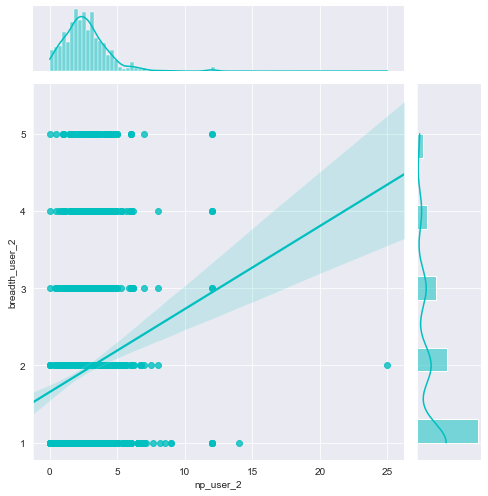

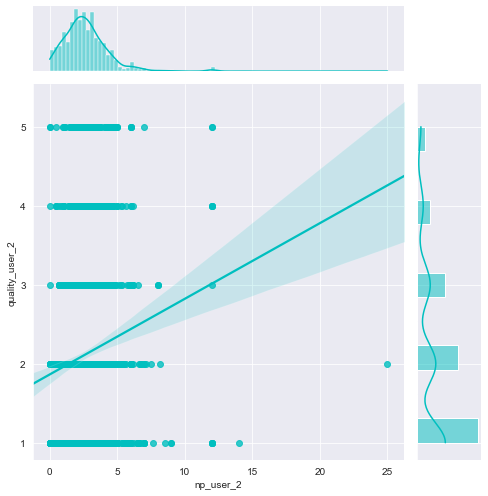

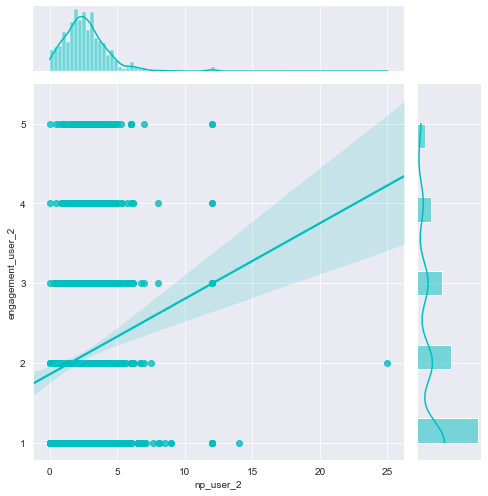

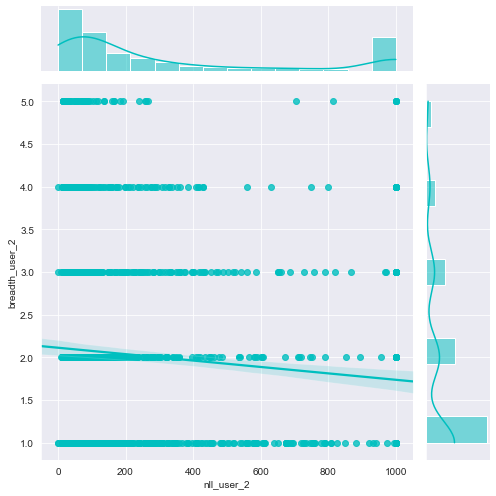

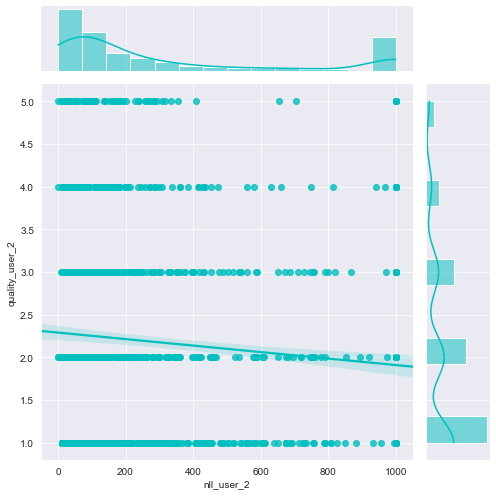

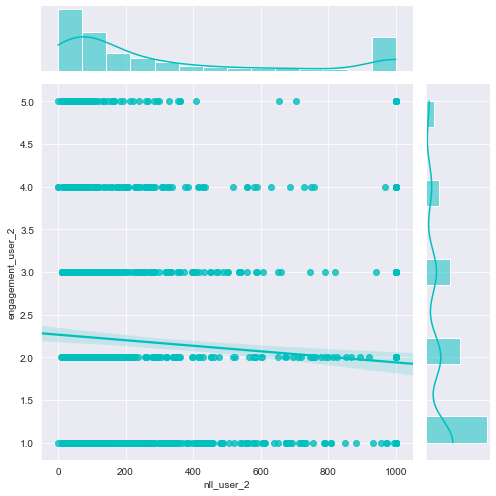

In [100]:
for in_metric in ['utt_user_2', 'np_user_2', 'nll_user_2']:
    for q_metric in ['breadth_user_2', 'quality_user_2', 'engagement_user_2']:
        sns.jointplot(x=in_metric, y=q_metric, data=df_hb,
                      kind="reg", truncate=False,
                      color="c", height=7)

### Corr coefficients and P-values

In [110]:
def calculate_pvalues(df, method='pearson'):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if method == 'pearson':
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            elif method == 'spearman':
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            elif method == 'kendall':
                pvalues[r][c] = round(kendalltau(df[r], df[c])[1], 4)
    return pvalues

#### Spearman

##### Humans

<AxesSubplot:>

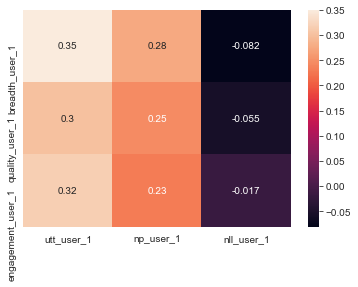

In [112]:
hh_init_qualit = df_hh.corr('spearman')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']]
sns.heatmap(hh_init_qualit, annot=True)

In [115]:
calculate_pvalues(df_hh)[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']]

,utt_user_1,np_user_1,nll_user_1
breadth_user_1,0.0,0.0002,0.0137
quality_user_1,0.0003,0.0019,0.0158
engagement_user_1,0.0003,0.0083,0.0261


##### Bots

<AxesSubplot:>

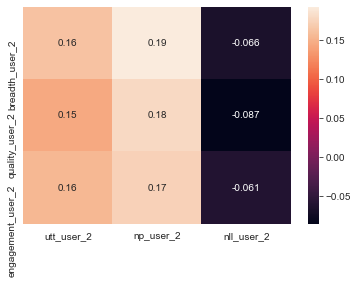

In [118]:
hb_init_qualit = df_hb.corr('spearman')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]
sns.heatmap(hb_init_qualit, annot=True)

In [119]:
calculate_pvalues(df_hb)[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]

,utt_user_2,np_user_2,nll_user_2
breadth_user_2,0.0139,0.0014,0.0054
quality_user_2,0.0782,0.0203,0.0007
engagement_user_2,0.0974,0.0999,0.0543


#### Pearson

##### Humans

<AxesSubplot:>

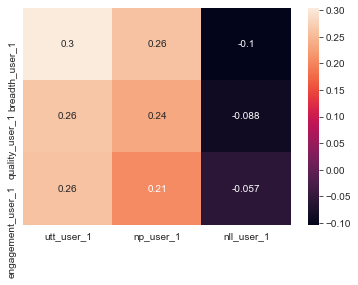

In [107]:
sns.heatmap(df_hh.corr('pearson')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']], annot=True)

In [116]:
calculate_pvalues(df_hh, 'pearson')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']]


,utt_user_1,np_user_1,nll_user_1
breadth_user_1,0.0,0.0002,0.0137
quality_user_1,0.0003,0.0019,0.0158
engagement_user_1,0.0003,0.0083,0.0261


##### Bots

<AxesSubplot:>

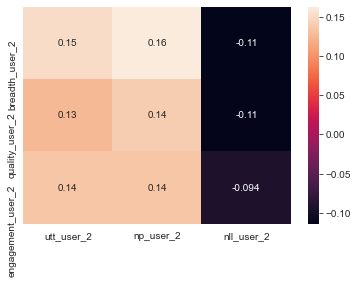

In [125]:
hb_init_qualit = df_hb.corr('pearson')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]
sns.heatmap(hb_init_qualit, annot=True)

In [123]:
calculate_pvalues(df_hb, 'pearson')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]

,utt_user_2,np_user_2,nll_user_2
breadth_user_2,0.0139,0.0014,0.0054
quality_user_2,0.0782,0.0203,0.0007
engagement_user_2,0.0974,0.0999,0.0543


#### Kendall

##### Humans

<AxesSubplot:>

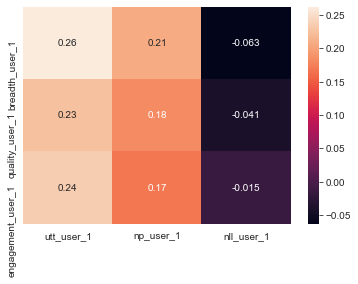

In [108]:
sns.heatmap(df_hh.corr('kendall')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']], annot=True)

In [117]:
calculate_pvalues(df_hh, 'kendall')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']]


,utt_user_1,np_user_1,nll_user_1
breadth_user_1,0.0,0.0,0.0513
quality_user_1,0.0,0.0002,0.0966
engagement_user_1,0.0,0.0003,0.2005


##### Bots

<AxesSubplot:>

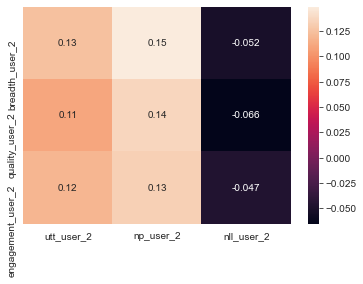

In [126]:
hb_init_qualit = df_hb.corr('kendall')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]
sns.heatmap(hb_init_qualit, annot=True)

In [127]:
calculate_pvalues(df_hb, 'kendall')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]

,utt_user_2,np_user_2,nll_user_2
breadth_user_2,0.0186,0.0008,0.475
quality_user_2,0.0481,0.0041,0.0244
engagement_user_2,0.0429,0.0375,0.5866
